<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Import image train and test image folders

In [48]:
import requests # HTTP requests
import zipfile # file extracting
from pathlib import Path # file management

image_path = Path("data/pizza_steak_sushi")

if image_path.is_dir():
  print(f"Image path already exists at {image_path}")
else:
  # create local image folder
  image_path.mkdir(parents=True, exist_ok=True)
  # download image file from github repository
  with open(image_path / ".zip", "wb") as f:
    print("Downloading .zip file")
    response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(response.content)

  # extract images from downloaded .zip file
  with zipfile.ZipFile(image_path / ".zip", "r") as z:
    print("Extracting .zip file")
    z.extractall(image_path)


Image path already exists at data/pizza_steak_sushi


In [49]:
train_dir = image_path / "train"
test_dir = image_path / "test"

#### Visualize a random image

Image class: steak
Image width: 512
Image height: 512


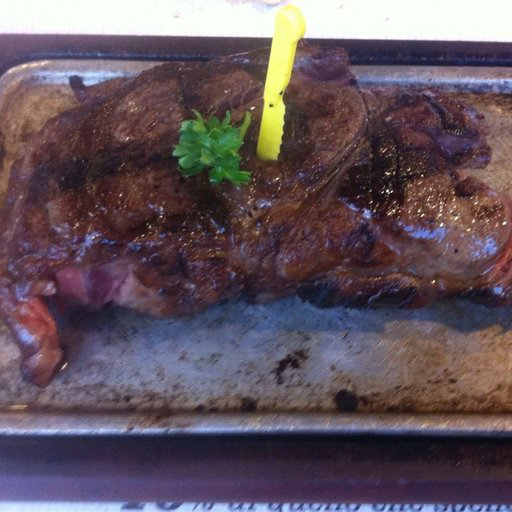

In [50]:
import random
from PIL import Image # Python Image Library

# set seed
random.seed(42)

# get all jpg images within the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# get path to random jpg img from the list
rand_image_path = random.choice(image_path_list)

# get the class label from the stem of the image file path
image_cls = rand_image_path.parent.stem

# open image using PIL
img = Image.open(rand_image_path)
print(f"Image class: {image_cls}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

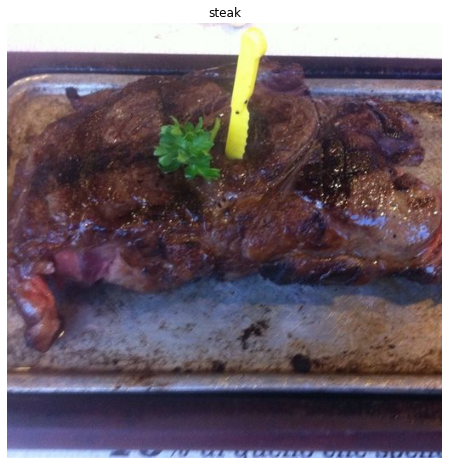

In [51]:
# visual image with matplotlib instead of PIL
import matplotlib.pyplot as plt
import numpy as np

# convert PIL image to numpy arrange before using matplotlib
img_np = np.asarray(img)

plt.figure(figsize=(8,8))
plt.imshow(img_np)
plt.title(image_cls)
plt.axis(False)
plt.show()

#### Transform the image dataset and create data loaders

In [52]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [53]:
# combine multiple transforms into a single transform using transform.compose()

data_transform = transforms.Compose(
    [transforms.Resize(size=(64, 64)), # resize all images to 64x64
     transforms.RandomHorizontalFlip(), # flip images at random (p=0.5)
     transforms.ToTensor() # convert to tensor to be used with PyTorch
    ]
)

In [54]:
# plot random sample of images and their corresponding transforms
def plot_image_transforms(image_list, transform, n_samples=3, rand_seed=42):
  random.seed(rand_seed)
  # sample a certain number of image file paths
  rand_image_list = random.sample(image_list, k=n_samples)

  # loop through each image file path
  for img_path in rand_image_list:
    # open the image at the file path using PIL
    with Image.open(img_path) as f:
      # plot original image
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].axis(False)

      # plot transformed image
      tr_img = transform(f)
      # update the ordering of image dimensions
      # pytorch uses (C, W, H) but matplotlib requires (W, H, C)
      tr_img = tr_img.permute(1, 2, 0)

      ax[1].imshow(tr_img)
      ax[1].axis(False)


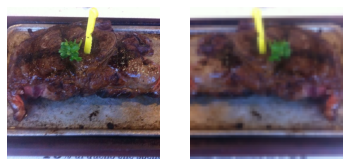

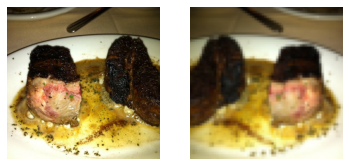

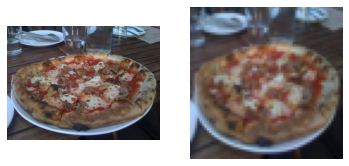

In [55]:
plot_image_transforms(image_path_list, data_transform)

### (1) Loading image data using ImageFolder

In [56]:
# create data loader using the image folder structure of the dataset
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

print(train_data)
print(test_dir)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
data/pizza_steak_sushi/test


In [57]:
# print training class names list
print(train_data.classes)
# print training class names and indexes dictionary
print(train_data.class_to_idx)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [58]:
# first image, label pair
image, label = train_data[0]
print(image.shape) # [3, 64, 64]
# print torch.float32 image pixels
print(image)
# print int image label
print(label)

torch.Size([3, 64, 64])
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157, 

#### Create a data loader

In [59]:
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [60]:
print(f"Number of batches in train data loader: {len(train_loader)}")
print(f"Number of batches in test data loader: {len(test_loader)}")

Number of batches in train data loader: 225
Number of batches in test data loader: 75


In [61]:
# select the data of the next iterator returned from the data
image, label = next(iter(train_loader))
print(image.shape) # [1, 3, 64, 64]
print(label.shape) # [1]

torch.Size([1, 3, 64, 64])
torch.Size([1])


### (2) Loading image data using custom data set

In [62]:
import os # file navigation
import pathlib # file path management
import torch
from PIL import Image # Python Image Library
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict # type hints for function prototypes

In [63]:
# get the class names of data set from the image file path
# create a sorted list of names of objects found in the training image file folder
file_class_names = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
# the way the image directories are structured means the directory objects are names of the classes
print(file_class_names)

['pizza', 'steak', 'sushi']


#### Create a list of class names from the image file directory structure

In [64]:
# function returns a list of class names as well as dictionary of class labels and index
# implementation of .classes and .class_to_idx  attributes
def get_class_names(dir: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted([entry.name for entry in list(os.scandir(dir))])

  if not classes:
    # no class names found, throw error
    raise FileNotFoundError("Could not find classes within given directory")

  # dictionary of class names and associated indexes
  class_to_idx = {cls: i for i, cls in enumerate(classes)}

  return classes, class_to_idx

#### Create a custom dataset by subclassing torch.utils.data.Dataset

In [65]:
# custom datasets must inherit from Datasets and override ___getitem__
class ImageDataset(Dataset):
  def __init__(self, target_dir: str, transform=None):
    # store a list of all jpg image file paths within traget directory
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = get_class_names(target_dir)

  # method for loading PIL image
  def load_image(self, index: int) -> Image.Image:
    # get specific image file path
    image_path = self.paths[index]
    return Image.open(image_path) # return the PIL image from image path

  def __len__(self): # optional
    # return the number of image files paths in the image dataset
    return len(self.paths)

  # return a single image, label data sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]: # required
    image = self.load_image(index)
    # get the associated label of the image using the image file directory
    cls_name = self.paths[index].parent.name
    # get the associated index of the label by indexing the dictionary of labels and indexes
    cls_idx = self.class_to_idx[cls_name]

    if self.transform:
      return self.transform(image), cls_idx
    else:
      return image, cls_idx

In [66]:
# transform for training data
train_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ]
)

# transform for test data
test_transform = transforms.Compose(
    # only reshape test data
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ]
)

In [67]:
# create traing and test dataset from image file folder
custom_train_data = ImageDataset(train_dir, train_transform)
custom_test_data = ImageDataset(test_dir, test_transform)

print(custom_train_data.classes)
print(custom_train_data.class_to_idx)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [68]:
def display_random_images(dataset: torch.utils.data.Dataset, classes: List[str], n: int = 10, random_seed: int = None):
  # limit n to display 10 images max
  n = 10 if n > 10 else n

  # set random seed if one exists
  if random_seed:
    random.seed(random_seed)

  # return a list of k random index samples
  random_sample_idx = random.sample(range(len(dataset)), k=n) # zero indexed range

  # setup plot using matplotlib
  plt.figure(figsize=(30, 5))

  for i, rand_index in enumerate(random_sample_idx):
    # get image and associated target label using random index from sampled indexes
    image, label = dataset[rand_index][0], dataset[rand_index][1]

    # change the position of channels dimension for matplotlib
    image = image.permute(1, 2, 0) # HWC

    plt.subplot(1, n, i+1) # 1 row, n columns
    plt.imshow(image)
    plt.title(classes[label])
    plt.axis(False)

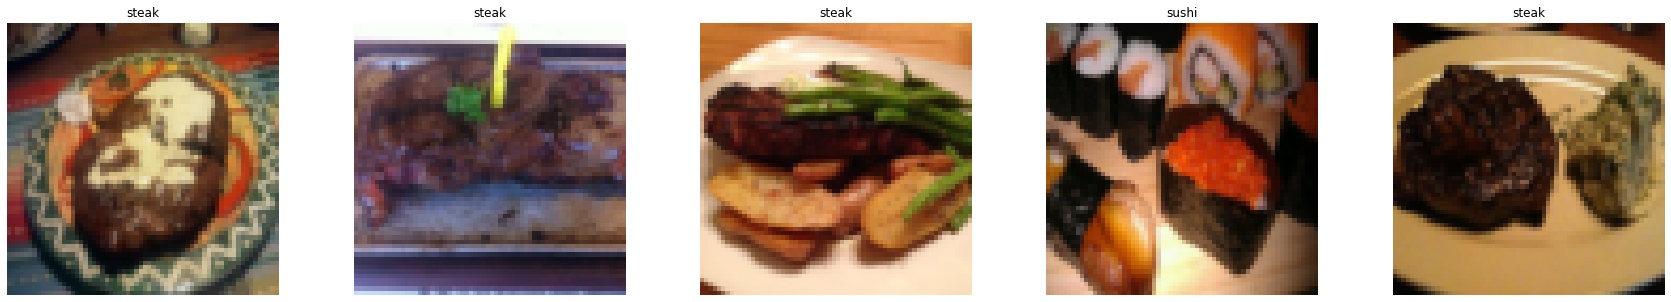

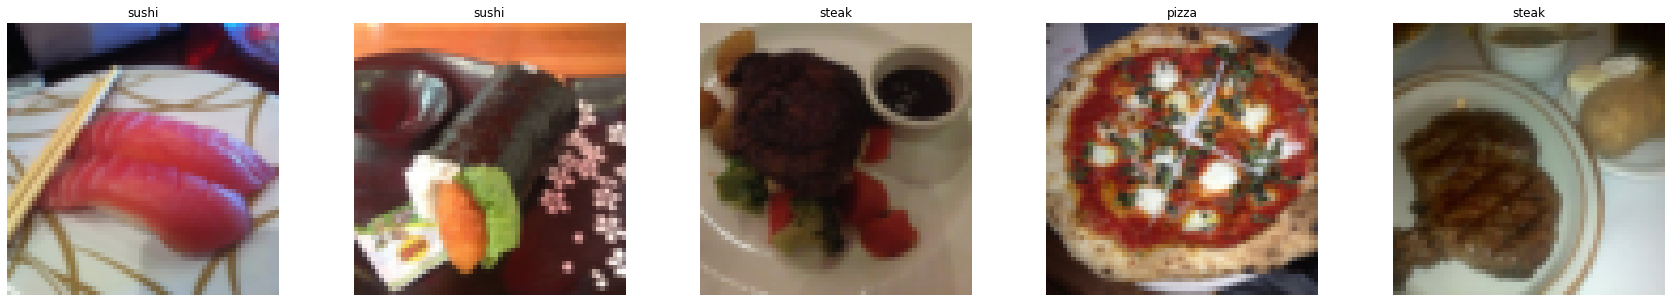

In [69]:
# display random images from created custom dataset
display_random_images(custom_train_data, custom_train_data.classes, n=5)
# display random images from inbuilt ImageFolder dataset
display_random_images(train_data, train_data.classes, n=5)

In [70]:
# since the custom dataset inherits from Dataset, it can be stored in a data loader as normal

custom_train_loader = DataLoader(custom_train_data, batch_size=1, shuffle=True)
custom_test_loader = DataLoader(custom_test_data, batch_size=1, shuffle=False)

print(f"Batches in custom train loader: {len(custom_train_loader)}")
print(f"Batches in custom test loader: {len(custom_test_loader)}")

Batches in custom train loader: 225
Batches in custom test loader: 75


### Data Augmentation

In [71]:
# TrivialAugmentWide() is a function that can be used to automatically and randomly augment images as part of the transofrm pipline

train_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31), # 0-31 range that indiciates the intensity of the random transforms to apply
        transforms.ToTensor()
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ]
)

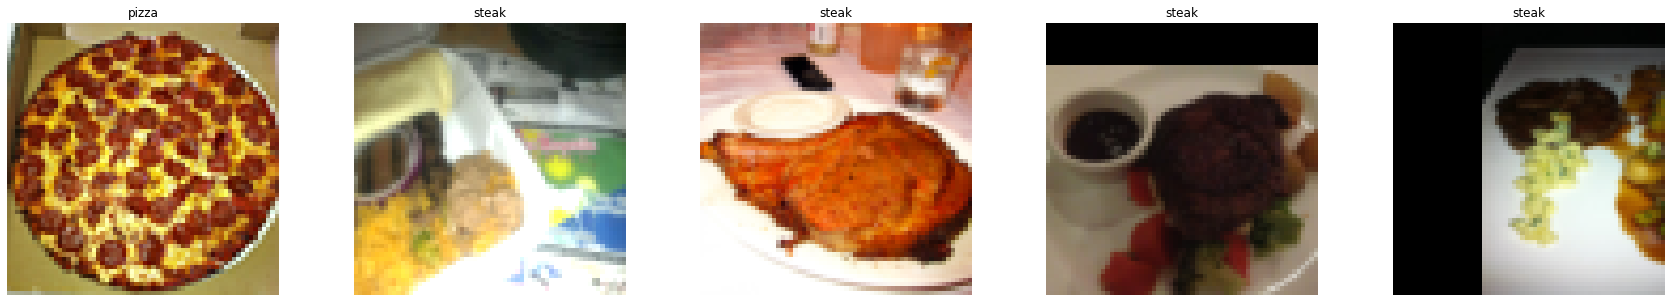

In [72]:
# create new traing and test datasets using the new transforms
new_custom_train_data = ImageDataset(train_dir, transform=train_transform)
new_custom_test_data = ImageDataset(test_dir, transform=test_transform)

# show random augmented images from training data
display_random_images(new_custom_train_data, new_custom_train_data.classes, n=5)

## TinyVGG (No Augmentation)

In [73]:
# simple transform
simple_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ]
)

In [74]:
# load data using inbuilt torchvision.datasets.ImageFolder()
train_data = datasets.ImageFolder(root=train_dir, transform=simple_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=simple_transform, target_transform=None)


In [75]:
# store datasets into data loaders
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

print(f"Train Loader")
print(f"Number of batches: {len(train_loader)} for a total of {len(train_loader) * BATCH_SIZE} samples")
print(f"Test Loader")
print(f"Number of batches: {len(test_loader)} for a total of {len(test_loader) * BATCH_SIZE} samples")

Train Loader
Number of batches: 8 for a total of 256 samples
Test Loader
Number of batches: 3 for a total of 96 samples


In [76]:
# Create TinyVGG model

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> int:
    super().__init__()
    # first convolutional block
    self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # second convolutional block
    self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # fully connected layer
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=output_shape),
    )

  def forward(self, x):
    return self.fc(self.conv_block2(self.conv_block1(x)))

# set manual seed for reproducibility
torch.manual_seed(42)
model1 = TinyVGG(3, 10, len(train_data.classes)).to(device)

### Predict using the model on a single instance of the data

In [77]:
# return the next available batch from the train data loader
images, labels = next(iter(train_loader))

image = images[0].unsqueeze(dim=0) # unsqueeze to add a single batch dimension to image
label = labels[0]
# allocate the image and label to the device
image = image.to(device)
label = label.to(device)
# predict using the model, converting logits to distribution and string label
pred_logits = model1(image)
pred_distro = torch.softmax(pred_logits, dim=1)
pred_label_idx = torch.argmax(pred_distro, dim=1)

print(pred_logits)
print(pred_distro)
print(pred_label_idx)
print(train_data.classes[pred_label_idx])
print(train_data.classes[label])

tensor([[0.0578, 0.0634, 0.0352]], grad_fn=<AddmmBackward0>)
tensor([[0.3352, 0.3371, 0.3277]], grad_fn=<SoftmaxBackward0>)
tensor([1])
steak
sushi


### Install TorchInfo to print a summary of how the model works with data

In [78]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model1, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [79]:
# import torchmetrics
!pip install torchmetrics

from torchmetrics import Accuracy
accuracy = Accuracy(task='multiclass', num_classes=3).to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
# train step function
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_func: torch.nn.Module, optimizer: torch.optim.Optimizer):
  # training mode
  model.train()

  train_loss, train_acc = 0.0, 0.0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    
    # forward pass
    logits = model(X)
    labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)

    # calculate loss
    loss = loss_func(logits, y)
    train_loss += loss.item()

    # calculate accuracy
    acc = accuracy(labels, y)
    train_acc += acc

    # zero grad
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # gradient descent
    optimizer.step

  # calculate the average loss and accuracy for whole batch 
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc



In [81]:
# test step function
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_func: torch.nn.Module):
  # evaluation model
  model.eval()
  
  test_loss, test_acc = 0.0, 0.0
  
  with torch.inference_mode():

    for batch, (X, y) in enumerate(dataloader):
      # allocate data to device
      X, y = X.to(device), y.to(device)

      # forward pass
      logits = model(X)
      labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)

      # calculate loss
      loss = loss_func(logits, y)
      test_loss += loss

      # calculate accuracy
      acc = accuracy(labels, y)
      test_acc += acc
    
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [82]:
from tqdm.auto import tqdm

# training loop function
def train(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          loss_func: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5):
  
  results = {'train_loss':[],
             'train_acc':[],
             'test_loss': [],
             'test_acc':[]}

  for epoch in tqdm(range(epochs)):
    # train step
    train_loss, train_acc = train_step(model, train_loader, loss_func, optimizer)
    # test step
    test_loss, test_acc = test_step(model, test_loader, loss_func)

    # print metrics for each epoch
    print(f"Epoch: {epoch + 1}")
    print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

    # store the metrics of each epoch
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results


In [83]:
# create loss function
loss_fn = nn.CrossEntropyLoss()
# create optimizer
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.001)

In [84]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model1_results = train(model1, train_loader, test_loader, loss_fn, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 1.09765 | Train Accuracy: 0.26% | Test Loss: 1.10373 | Test Accuracy: 0.21%
Epoch: 2
Train Loss: 1.09752 | Train Accuracy: 0.26% | Test Loss: 1.10373 | Test Accuracy: 0.21%
Epoch: 3
Train Loss: 1.09719 | Train Accuracy: 0.38% | Test Loss: 1.10373 | Test Accuracy: 0.21%
Epoch: 4
Train Loss: 1.09749 | Train Accuracy: 0.26% | Test Loss: 1.10373 | Test Accuracy: 0.21%
Epoch: 5
Train Loss: 1.09732 | Train Accuracy: 0.38% | Test Loss: 1.10373 | Test Accuracy: 0.21%


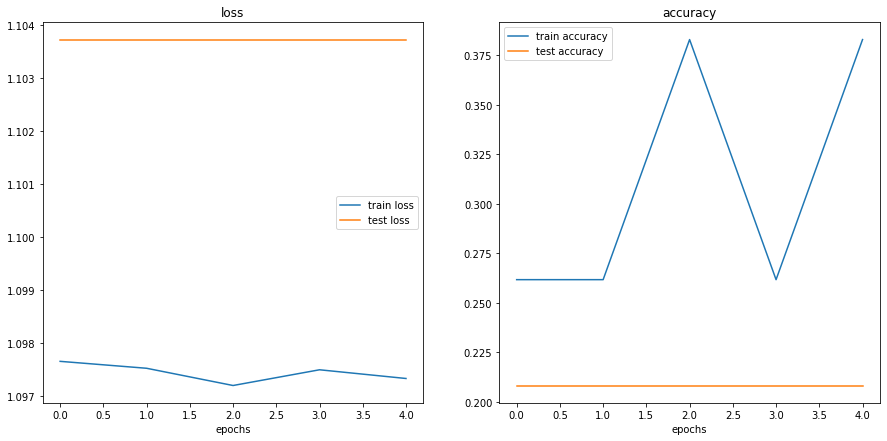

In [85]:
# plot the loss curves for train and test results

def plot_loss_curves(results: Dict[str, List[float]]):
  # get loss metrics
  train_loss = results['train_loss']
  test_loss = results['test_loss']
  # get accuracy metrics
  train_acc = results['train_acc']
  test_acc = results['test_acc']

  # create a range between 0 and epochs-1
  n_epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15, 7))

  # plot loss
  plt.subplot(1, 2, 1)
  plt.plot(n_epochs, train_loss, label='train loss')
  plt.plot(n_epochs, test_loss, label='test loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()
  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(n_epochs, train_acc, label='train accuracy')
  plt.plot(n_epochs, test_acc, label='test accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

plot_loss_curves(model1_results)

How to fix overfitting:


*   Larger training dataset
*   Simplify the model (e.g. shallower network)
*   Data augmentation (greater variety of training data)
*   Transfer Learning
*   Dropout
*   Learning rate decay (adaptive optimizers)
*   Early stopping

How to fix underfitting:


*   More complex model(e.g. deeper network, more units)
*   Smaller learning rate for gradient descent
*   Transfer Learning
*   Train for longer
*   Less regularization (e.g. no dropout)



## TinyVVG (With Data Augmentation)

In [86]:
# training dataset transform
train_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor()
    ]
)

# test dataset transform
test_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ]
)

In [87]:
# create datasets using ImageFolder()
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform, target_transform=None)

# create training and test data loaders
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [88]:
# instantiate new model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model2 = TinyVGG(input_shape=3, hidden_units=10, output_shape=3).to(device)

In [89]:
# loss function
loss_func = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.001)

In [90]:
model2_results = train(model2, train_loader, test_loader, loss_func, optimizer)
print(model2_results)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 1.09751 | Train Accuracy: 0.28% | Test Loss: 1.10373 | Test Accuracy: 0.21%
Epoch: 2
Train Loss: 1.09710 | Train Accuracy: 0.39% | Test Loss: 1.10373 | Test Accuracy: 0.21%
Epoch: 3
Train Loss: 1.09762 | Train Accuracy: 0.26% | Test Loss: 1.10373 | Test Accuracy: 0.21%
Epoch: 4
Train Loss: 1.10068 | Train Accuracy: 0.27% | Test Loss: 1.10373 | Test Accuracy: 0.21%
Epoch: 5
Train Loss: 1.10045 | Train Accuracy: 0.28% | Test Loss: 1.10373 | Test Accuracy: 0.21%
{'train_loss': [1.0975127518177032, 1.0970952808856964, 1.0976169258356094, 1.1006838977336884, 1.1004452854394913], 'train_acc': [tensor(0.2812), tensor(0.3867), tensor(0.2617), tensor(0.2734), tensor(0.2812)], 'test_loss': [tensor(1.1037), tensor(1.1037), tensor(1.1037), tensor(1.1037), tensor(1.1037)], 'test_acc': [tensor(0.2083), tensor(0.2083), tensor(0.2083), tensor(0.2083), tensor(0.2083)]}
